In [30]:
%matplotlib ipympl

import seaborn as sns
sns.set_theme()
sns.set_context('talk')

import os, glob, re
from pathlib import Path

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import ipywidgets as ipy

from scipy.optimize import curve_fit
import scipy.interpolate as interpolate

import math
import gc
import pandas as pd

from silx.io.specfile import SpecFile
import fabio
import pyFAI

from pyFAI.multi_geometry import MultiGeometry
from pyFAI.gui import jupyter
from pyFAI.azimuthalIntegrator import AzimuthalIntegrator as AzInt
import scipy.io

from collections import OrderedDict

import warnings
warnings.filterwarnings('ignore')

AA = '\mathrm{\AA}^{-1}'

## function below is CURRENTLY HARD CODED FOR PILATUS IMAGES

In [48]:
def read_image(file, shape=(195, 487), dtype='int32', header_skip=4096, flip=False):
    """
    Generic function to read TIFF and RAW files. Assumes specific structure.
    TIFF files have a header to skip, RAW files don't.
    """
    try:
        with open(file, 'rb') as im:
            if file.suffix in ['tif', 'tiff']:
                im.seek(header_skip)
            arr = np.frombuffer(im.read(), dtype=dtype)
            arr = arr.reshape(shape)
        if flip:
            arr = np.fliplr(arr)
        return arr.astype(float)
    except Exception as e:
        print(f"Error reading file: {file}, Error: {str(e)}")
        return None


def get_from_spec_file(fname, scan_number, cols):
    scan_data = SpecFile(str(fname))[scan_number - 1]

    spec_data = {}
    for col in cols:
        if col in scan_data.labels:
            spec_data[col] = scan_data.data_column_by_name(col)
        elif col in scan_data.motor_names:
            spec_data[col] = scan_data.motor_position_by_name(col) 
        else:
            print(f'{col} does not exist')
    return spec_data

## Initialize paths. 
*  Assumes images are in a subdirectory of the spec-path
*  Assumes export directory exists (try creating one programatically?)
*  Uses spec file to translate detector
*  Only tested for pliatus 100k in horizontal orientation

In [14]:
base_path = Path(r'/msd_data/checkout/bl17-2/user_data/2024_04_McIntyre')

exportPath = base_path / 'export'

spec_n = 'TiN_200C'
spec_path = base_path / spec_n

specFiles = list(spec_path.glob('*.csv')) # use re to be more precise

# Specify the folder and scan numbers for each spec file
spec_scans = {
    'TiN_200C': ('TiN_200C', [2] + list(range(3,23))),
    'TiN_250C_10nm_RT': ('samples', [1, 3]),
    'TiN_200C_RT': ('samples', [1, 2, 3]),
    'TiN_200C_RT_April2': ('samples', [1, 2, 3]),
}

specs = [pd.read_csv(str(x), index_col=0).rename(columns=lambda x: x.strip()) for x in specFiles]
user = 'checkout_'
imgPath = spec_path / 'images'

In [ ]:
# Set up pyFAI integrator

## for Feb centerPx1, centerPx2 = (236, 91) 
# portrait mode?
portrait = True

# define detector.  
det = pyFAI.detectors.Pilatus100k()

# define detector geometry
centerPx1, centerPx2 = (243, 97) 
rot3 = 0
if portrait:
    centerPx2, centerPx1 = centerPx1, centerPx2
    rot3 = np.pi/2 

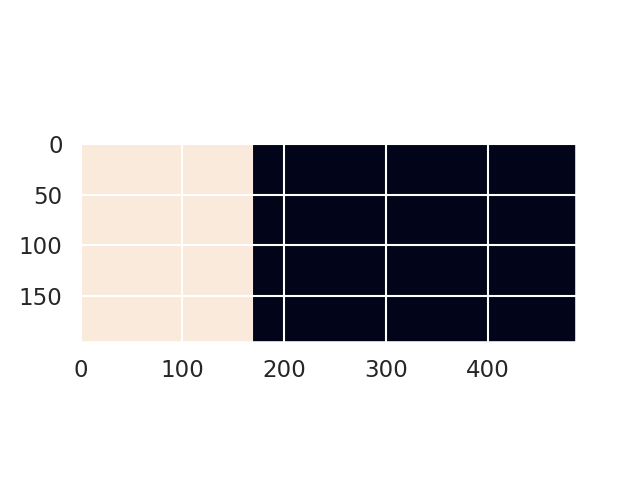

In [57]:
plt.figure()
lst_mask[:, 470:] = 1
plt.imshow(lst_mask)

Mo_10nm_296K_start_April3_BeTest #2
Mo_10nm_296K_start_April3_BeTest #3


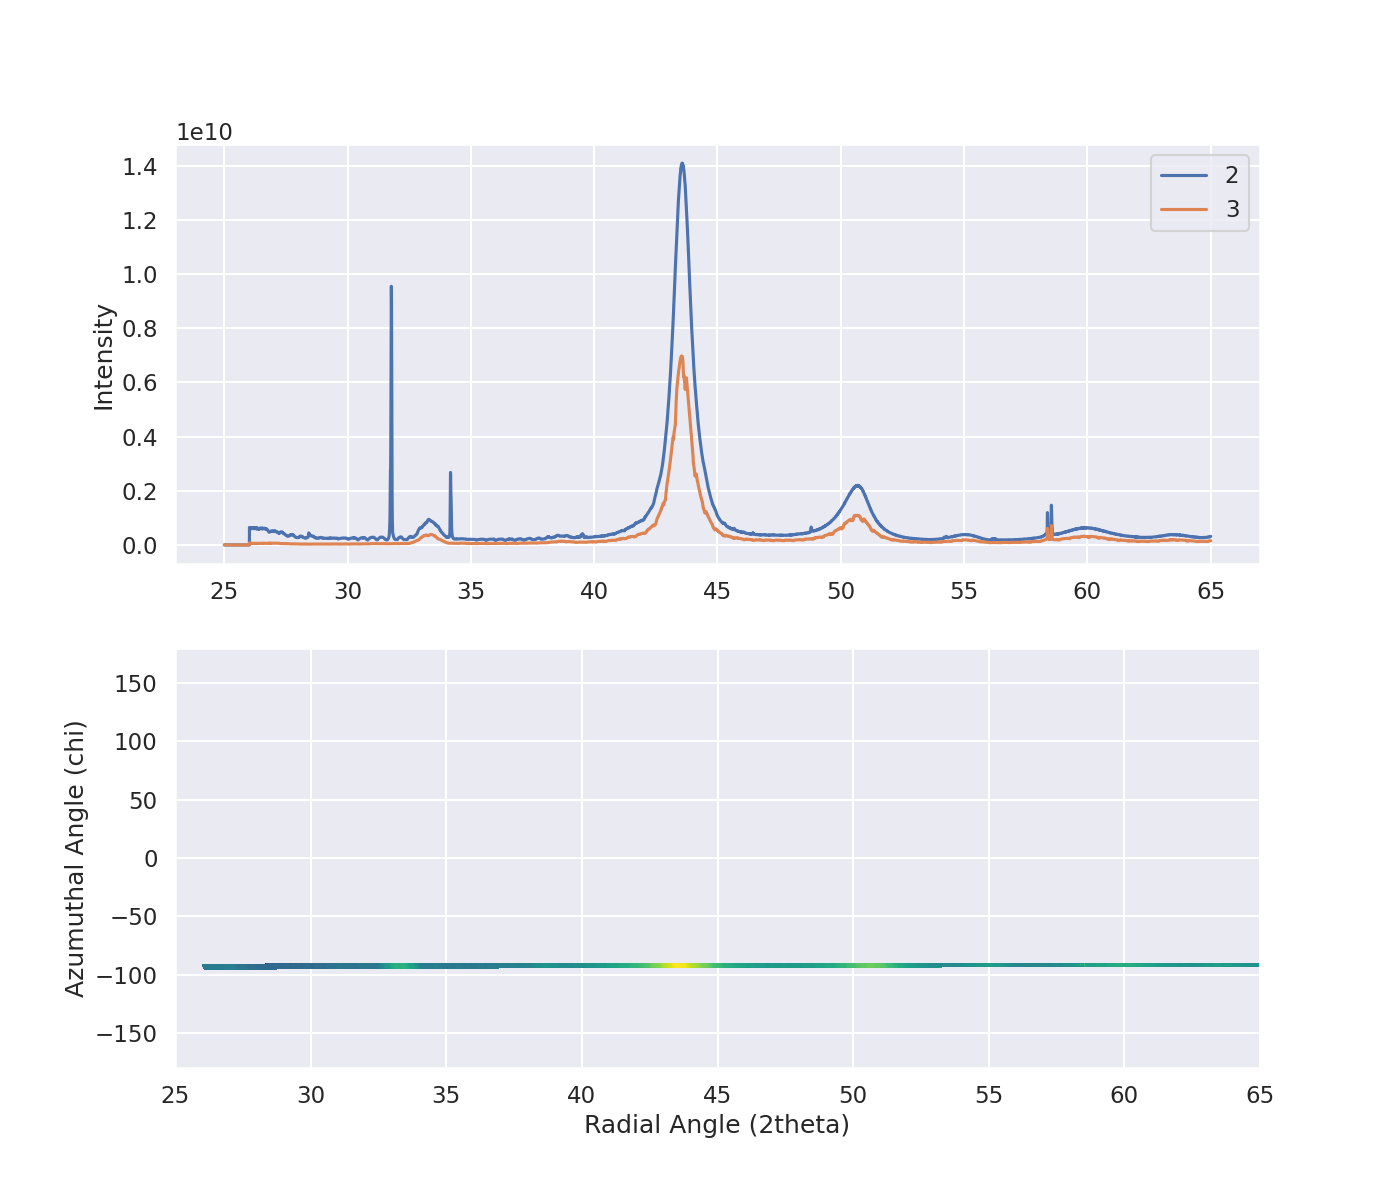

In [58]:
base_path = Path(r'/msd_data/checkout/bl17-2/user_data/2024_04_McIntyre')
img_path = base_path / 'images'

spec_folder = 'samples'
spec_path = base_path / spec_folder

spec_scans = {
    # 'Be_RT': ('samples', [1]), 
    'Mo_10nm_296K_start_April3_BeTest': ('samples', [2, 3]),
}

#######################################################################
###      Start scan information and integration here...
#######################################################################

fig, axs = plt.subplots(2, 1, figsize=(14,12))

lst_mask = det.mask
lst_mask[:, :200] = 1
lst_mask[:, 450:] = 1

for spec_name, (spec_folder, scan_numbers) in spec_scans.items():
    spec_path = base_path / spec_folder
    fname = spec_path / spec_name
    for scan_num in scan_numbers:
        dict_key = f'{spec_name} #{scan_num}'
        #if dict_key in xy.keys():
        #    continue
        print(dict_key)
    
        # print(scan_num)
        cols_dict = get_from_spec_file(str(fname), scan_num, ['del', 'i0', 'i1'])
        tth, i0, i1 = cols_dict['del'], cols_dict['i0'], cols_dict['i1']

        imgs = []
        ais = []

        for k in range(1, len(tth)):
            filename = next(img_path.glob(f'*{spec_name}_scan{scan_num}_{k:04}.raw'))
            # print('\r', filename, end='\r')
            data = read_image(filename, flip=True)#, mask=)

            imgs.append(data)
            ai = AzInt(dist=distance, poni1=centerPx1*det.pixel1, poni2=centerPx2*det.pixel1, detector=det, 
                   wavelength=wavelength, rot1=np.pi/180*float(tth[k-1]), rot3=rot3)
                   #wavelength=wavelength, rot1=np.pi/180*float(spec['TwoTheta'][scanNo]), rot3=rot3)
            ais.append(ai)
   
        mg = MultiGeometry(ais, unit="2th_deg", radial_range=(25, 65))#, azimuth_range=(-120,-45))
        int1d = mg.integrate1d(imgs, 10000, lst_mask=lst_mask)

        xy[dict_key] = (fname, scan_num,  int1d[0], int1d[1])
        
        axs[0].plot(int1d[0], int1d[1], label=f'{scan_num}')
        axs[0].set_ylabel('Intensity')

        res2d = mg.integrate2d(imgs, 1000, 360)
        # gives 3 arrays.  First is intensities with shape (arg2, arg1)  Second is 2th range, third is azimuthal range

        axs[1].pcolormesh(res2d[1], res2d[2], np.log(res2d[0]), cmap = 'viridis')

        axs[1].set_xlim(25, 65)
        axs[1].set_xlabel('Radial Angle (2theta)')

        axs[1].set_ylabel('Azumuthal Angle (chi)')

axs[0].legend();

interactive(children=(Dropdown(description='Scan', index=2, options=('Be_RT #1', 'Mo_10nm_296K_start_April3_Be…

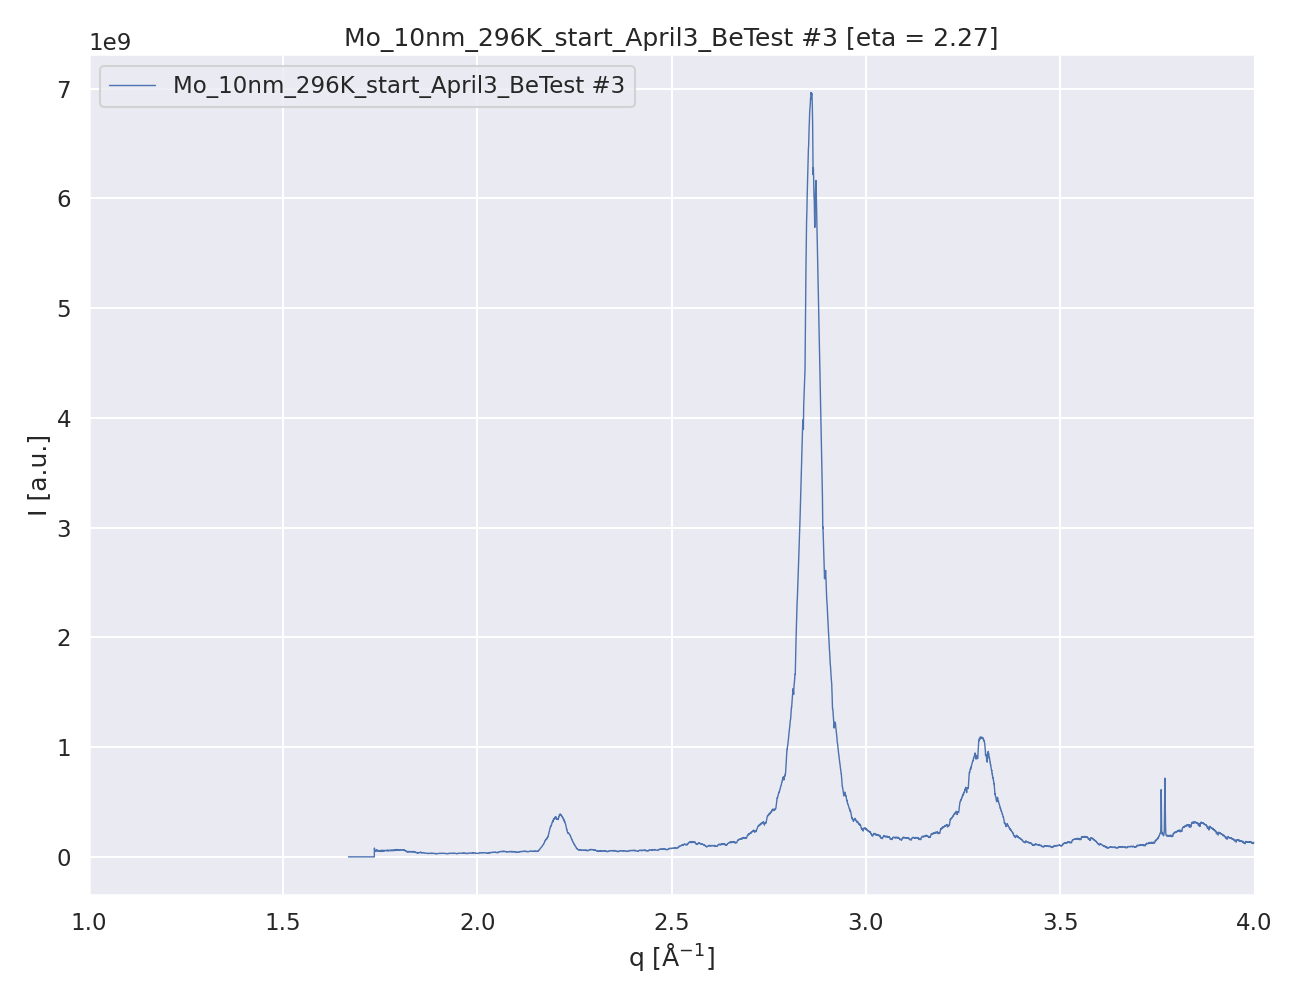

In [59]:
fig2, ax2 = plt.subplots(ncols=1, figsize=(13, 10))

energy = 7.605 # keV

labels = []
processed_scans = list(xy.keys())
xlim_widget = ipy.FloatRangeSlider(min=0, max=70, value=(1, 4), step=0.1)
#xlim_widget = ipy.FloatRangeSlider(step=0.1)
#NSlider = ipy.IntSlider(min=1, max=2, step=1, value=0)

@ipy.interact(Scan=ipy.Dropdown(options=processed_scans, value=processed_scans[-1]),
          xaxis=ipy.Dropdown(options=['q', 'tth'], value='q'),
          log=False,
          xlim=xlim_widget,
          overlay=False
         )
def show_iq(Scan, xaxis, xlim, log, overlay):
    if not overlay:
        ax2.cla()
        labels.clear()
    ax2.grid(True)
    
    fname, scan_num, tth, i_q = xy[Scan]
    q = 4 * np.pi * energy / 12.398 * np.sin(np.deg2rad(tth)/2)

    x, xlabel = q, f'q [${AA}$]'
    if xaxis == 'tth':
        x, xlabel = tth, rf'2$\theta$ [degrees]'
    xlim_widget.value = (x.min(), x.max())

    #scan_num = int(Scan[Scan.rfind('#')+1:])
    eta_val = get_from_spec_file(fname, scan_num, ['eta'])['eta']
    
    if Scan not in labels:
        ax2.plot(x, i_q, '-', ms=4, lw=1, label=Scan)
        labels.append(Scan)
    
    ax2.set_xlim(xlim)
    ax2.set_xlabel(xlabel)
    ax2.set_ylabel('I [a.u.]')
    if log:
        ax2.set_yscale('log')
        ax2.set_ylabel('log(I) [a.u.]')
        
    ax2.set_title(f'{Scan} [eta = {eta_val}]')
    ax2.legend()
    
    fig2.tight_layout()

In [27]:
testPath = os.path.join(imgPath, 'b_mehta_calibration_directbeam_4Nov2020_scan1_0050.raw')
print(testPath)
img = load_image(testPath)
plt.imshow(np.rot90(img, k=-1))
plt.scatter(95, 237, c='r')

C:\Users\roberttk\Desktop\SLAC_RA\DATA\2-1_calibration_test\JL02\images\b_mehta_calibration_directbeam_4Nov2020_scan1_0050.raw


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\roberttk\\Desktop\\SLAC_RA\\DATA\\2-1_calibration_test\\JL02\\images\\b_mehta_calibration_directbeam_4Nov2020_scan1_0050.raw'